---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

In [50]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
import metpy

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a problem that a naive network has.

## Data

In [2]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [3]:
from pathlib import Path

In [4]:
Path("./NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc").is_file()

True

In [5]:
from jejeqx._src.datamodules.natl60 import SSHNATL60

select = {"time": slice("2013-01-01", "2013-01-01")}
iselect = {"time": 0}

dm = SSHNATL60(select=select)
dm.setup()

In [6]:
x, y = dm.ds_test[:]


In [9]:
from dataclasses import dataclass, field
from typing import List, Dict

@dataclass
class Subset:
    _target_: str = "builtins.slice"
    _args_: List = field(default_factory=lambda :["2013-01-01", "2013-01-01"])


@dataclass
class SSHDM:
    _target_: str = "jejeqx._src.datamodules.natl60.SSHNATL60"
    batch_size: int = 10_000
    shuffle: bool = False
    split_method: str = "even"
    train_size: float = 0.85
    coords: List = field(default_factory=lambda : ["x", "y", "z"])
    variables: List = field(default_factory=lambda : ["ssh"])
    coarsen: Dict = field(default_factory=lambda : {"lon": 2, "lat": 2})
    



In [10]:
from sklearn import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF
# from sklearn.preprocessing import MinMaxScaler

In [11]:
# spatial transform
transforms = Pipeline([
    ("cartesian3d", Spherical2Cartesian(radius=1.0, units="degrees")),
    ("spatialminmax", MinMaxDF(["x", "y", "z"], -1, 1)),
    ("timedelta", TimeDelta("2012-10-01", 1, "s")),
    ("timeminmax", MinMaxDF(["time"], -1, 1)),
])


In [12]:
select = {"time": slice("2013-01-01", "2013-01-01")}

config_dm = OmegaConf.structured(SSHDM())

dm = hydra.utils.instantiate(config_dm, select=select, transforms=transforms)

dm.setup()


init = dm.ds_train[:32]
x_init, y_init = init
x_init.min(), x_init.max(), x_init.shape

(-1.0, 0.4671298040200087, (32, 3))

In [13]:
xrda = dm.load_xrdata()

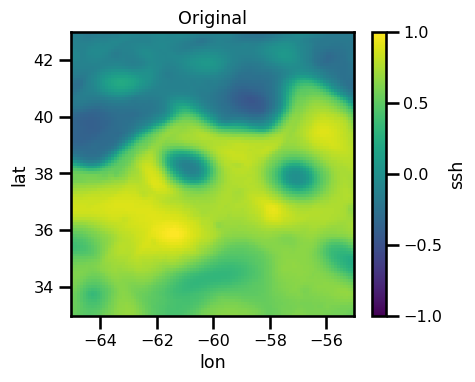

In [14]:
fig, ax = plt.subplots(ncols=1, figsize=(5,4))

xrda.ssh.isel(time=0).plot.pcolormesh(ax=ax, cmap="viridis")
ax.set(title="Original")

plt.tight_layout()
plt.show()

In [15]:
# lr = 5e-3
# num_epochs = 5_000
# num_steps_per_epoch = len(dm.ds_train)

# @dataclass
# class FoxDataModule:
#     _target_: str = "jejeqx._src.datamodules.image.ImageFox"
#     batch_size: int = 10_000
#     train_size: float = 0.5
#     shuffle: bool = False
#     split_method: str = "even"
#     resize: int = 4
    
# @dataclass
# class Training:
#     num_epochs: int = 2_000

# @dataclass
# class Model:
#     _target_: str = "jejeqx._src.nets.nerfs.siren.SirenNet"
#     in_size: int = 2
#     out_size: int = 3
#     width_size: int = 128
#     depth: int = 5

# @dataclass
# class Optimizer:
#     _target_: str = "optax.adam"
#     learning_rate: float = lr
    
# @dataclass
# class Scheduler:
#     _target_: str = "optax.warmup_cosine_decay_schedule"
#     init_value: float = 0.0
#     peak_value: float = lr
#     warmup_steps: int = 100
#     decay_steps: int = int(num_epochs * num_steps_per_epoch)
#     end_value: float = 0.01 * lr
    
# @dataclass
# class Config:
#     datamodule: FoxDataModule = FoxDataModule()
#     model: Model = Model()
#     optimizer: Optimizer = Optimizer()
#     scheduler: Scheduler = Scheduler()
#     num_epochs: int = 2_000

In [16]:
# import optax

# config = Config()
# config = OmegaConf.structured(Config())

# # initialize datamodule
# dm = hydra.utils.instantiate(config.datamodule)

# dm.setup()


# # initialize optimizer
# optimizer = hydra.utils.instantiate(config.optimizer)

# # initialize scheduler
# num_steps_per_epoch = len(dm.ds_train)
# decay_steps = int(num_steps_per_epoch * config.num_epochs)
# schedule_fn = hydra.utils.instantiate(config.scheduler, decay_steps=decay_steps)

# # initialize optimizer + scheduler
# optimizer = optax.chain(optimizer, optax.scale_by_schedule(schedule_fn))



In [17]:
# ibatch = next(iter(dm.train_dataloader()))

# print(ibatch[0].shape, ibatch[1].shape, type(ibatch[0]))

## Model

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

### MLP Layer

$$
\mathbf{f}_\ell(\mathbf{x}) = \sigma\left(\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} \right)
$$

where $\sigma$ is the *swish* activation function.

$$
\sigma(\mathbf{x}) = \mathbf{x} \odot \text{Sigmoid}(\mathbf{x})
$$

In [18]:
from typing import Dict
from dataclasses import field


@dataclass
class Activation:
    # _target_: str = "jejeqx._src.nets.activations.Tanh"
    _target_: str = "jejeqx._src.nets.activations.ReLU"
    # _target_: str = "jejeqx._src.nets.activations.Swish"

@dataclass
class Identity:
    _target_: str = "equinox.nn.linear.Identity"
    
@dataclass
class MLPModel:
    _target_: str = "equinox.nn.MLP"
    in_size: int = 3
    out_size: int = 1
    width_size: int = 128
    depth: int = 5
    activation: Activation = Activation()
    final_activation: Identity = Identity()




In [19]:
# initialize model
model_config = OmegaConf.structured(MLPModel())

model = hydra.utils.instantiate(model_config, key=jrandom.PRNGKey(123))

# check output of models
out = jax.vmap(model)(x_init)

assert out.shape == y_init.shape
# eqx.tree_pprint(model)

## Optimizer (+ Learning Rate)

For this, we will use a simple adam optimizer with a `learning_rate` of 1e-4. From many studies, it appears that a lower learning rate works well with this methods because there is a lot of data. In addition, a bigger `batch_size` is also desireable. We will set the `num_epochs` to `1_000` which should be good enough for a single image. Obviously more epochs and a better learning rate scheduler would result in better results but this will be sufficient for this demo.

In [20]:
@dataclass
class Optimizer:
    _target_: str = "optax.adam"
    learning_rate: float = 1e-4

In [21]:
optim_config = OmegaConf.structured(Optimizer())

optim = hydra.utils.instantiate(optim_config)

### Scheduler

<p align="center">
<img src="http://www.bdhammel.com/assets/learning-rate/resnet_loss.png" alt="drawing" width="300"/>
<figcaption align = "center">
  <b>Fig.1 - An example for learning rate reduction when the validation loss stagnates. Source: 
    <a href="http://www.bdhammel.com/assets/learning-rate/resnet_loss.png">Blog</a>
  </b>
  </figcaption>
</p>

We will use a simple learning rate scheduler - `reduce_lr_on_plateau`. This will automatically reduce the learning rate as the validation loss stagnates. It will ensure that we really squeeze out as much performance as possible from our models during the training procedure.We start with a (relatively) high `learning_rate` of `1e-4` so we will set the `patience` to 5 epochs. So if there is no change in with every epoch, we decrease the learning rate by a factor of `0.1`.

This is a rather crude (but effective) method but it tends to work well in some situations. A better method might be the `cosine_annealing` method or the `exponential_decay` method. See other [examples](https://www.kaggle.com/code/snnclsr/learning-rate-schedulers/).

In [22]:
import optax

@dataclass
class Scheduler:
    _target_: str = "optax.warmup_cosine_decay_schedule"
    init_value: float = 0.0
    peak_value: float = 1e-0
    warmup_steps: int = 500
    end_value: float = 1e-5
    
scheduler_config = OmegaConf.structured(Scheduler())

In [23]:
num_epochs = 3_000
num_steps_per_epoch = len(dm.ds_train)

scheduler = hydra.utils.instantiate(
    scheduler_config, decay_steps=int(num_epochs * num_steps_per_epoch)
)

In [24]:
optimizer = optax.chain(optim, optax.scale_by_schedule(scheduler))

## Trainer Module

In [25]:
import glob
import os
from pathlib import Path

from jejeqx._src.trainers.base import TrainerModule
from jejeqx._src.trainers.callbacks import wandb_model_artifact
from jejeqx._src.losses import psnr


class RegressorTrainer(TrainerModule):
    def __init__(self,
                 model,
                 optimizer,
                 **kwargs):
        super().__init__(
            model=model, 
            optimizer=optimizer, 
            pl_logger=None,
            **kwargs
        )

    def create_functions(self):

        @eqx.filter_value_and_grad
        def mse_loss(model, batch):
            x, y = batch
            pred = jax.vmap(model)(x)
            loss = jnp.mean((y - pred)**2)
            return loss
        
        def train_step(state, batch):
            
            loss, grads = mse_loss(state.params, batch)
            state = state.update_state(state, grads)
            psnr_loss = psnr(loss) 
            metrics = {"loss": loss, "psnr": psnr_loss}
            return state, loss, metrics

        def eval_step(model, batch):
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss) 
            return {"loss": loss, "psnr": psnr_loss}
        
        def predict_step(model, batch):
            x, y = batch
            out = jax.vmap(model)(x)
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss)
            return out, {"loss": loss, "psnr": psnr_loss}

        return train_step, eval_step, predict_step
    
    
    def on_training_end(self,):
        
        if self.pl_logger:
            save_dir = Path(self.log_dir).joinpath(self.save_name)
            self.save_model(save_dir)
            wandb_model_artifact(self)
            self.pl_logger.finalize("success")
        
        


In [26]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)
train_more = False


In [27]:
trainer.load_model("checkpoint_model_mlp_ssh.ckpt")

In [28]:
%%time

if train_more:
    metrics = trainer.train_model(dm, num_epochs=num_epochs)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs


In [29]:
trainer.save_model("checkpoint_model_mlp_ssh.ckpt")
# trainer.save_state("checkpoint_state.ckpt")

In [30]:
out, metrics = trainer.predict_model(dm.predict_dataloader())
metrics

{'loss': 0.0012780825913441657, 'psnr': 59.69247119090066}

In [31]:
xrda["ssh_mlp"] = dm.data_to_df(out).to_xarray().ssh

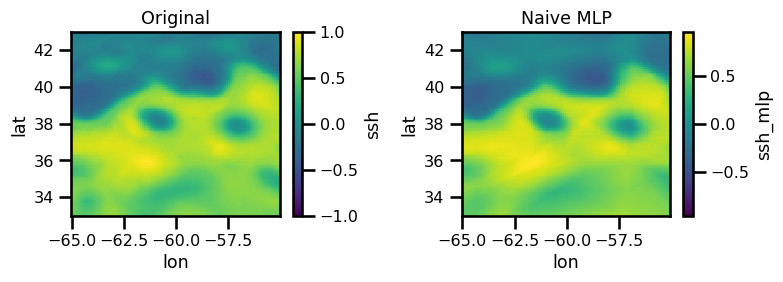

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(8,3))

xrda.ssh.isel(time=0).plot.pcolormesh(ax=ax[0], cmap="viridis")
ax[0].set(title="Original")

xrda.ssh_mlp.isel(time=0).plot.pcolormesh(ax=ax[1], cmap="viridis")
ax[1].set(title="Naive MLP")

plt.tight_layout()
plt.show()

## Custom Activation Functions


**SIREN**

One of the most famous methods is the SIREN method. This replaces the standard activation function, $\sigma$, with a sinusoidal function.

$$
\phi(\mathbf{x})_\ell = \sin 
\left( \omega_\ell\left( 
\mathbf{w}_\ell\mathbf{x} + \mathbf{b}_\ell
\right)\right)
$$

In [36]:
@dataclass
class Key:
    _target_: str = "jax.random.PRNGKey"
    seed: int = 123

@dataclass
class SirenBasis:
    _target_: str = "jejeqx._src.nets.nerfs.siren.SirenNet"
    in_size: int = 3
    out_size: int = 128
    width_size: int = 128
    depth: int = 5
    key: Key = Key()
    
@dataclass
class LinearModel:
    _target_: str = "equinox.nn.Linear"
    in_features: int = 128
    out_features: int = 1
    use_bias: bool = True
    key: Key = Key()
    
@dataclass
class NerFModel:
    _target_: str = "jejeqx._src.nets.nerfs.base.NerF"
    basis_net: SirenBasis = SirenBasis()
    network: LinearModel = LinearModel()

In [37]:
# initialize model
model_config = OmegaConf.structured(NerFModel())

model = hydra.utils.instantiate(model_config)

# check output of models
out = jax.vmap(model)(x_init)

assert out.shape == y_init.shape


In [38]:
# eqx.tree_pprint(model)

In [40]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)

train_more = False

In [41]:
trainer.load_model("checkpoint_model_siren_ssh.ckpt")

In [42]:
%%time

if train_more:

    metrics = trainer.train_model(dm, num_epochs=num_epochs)

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 4.29 µs


In [43]:
trainer.save_model("checkpoint_model_siren_ssh.ckpt")

In [44]:
out, metrics = trainer.predict_model(dm.predict_dataloader())
metrics

{'loss': 0.00040844511287541475, 'psnr': 71.10005834737818}

In [45]:
xrda["ssh_siren"] = dm.data_to_df(out).to_xarray().ssh

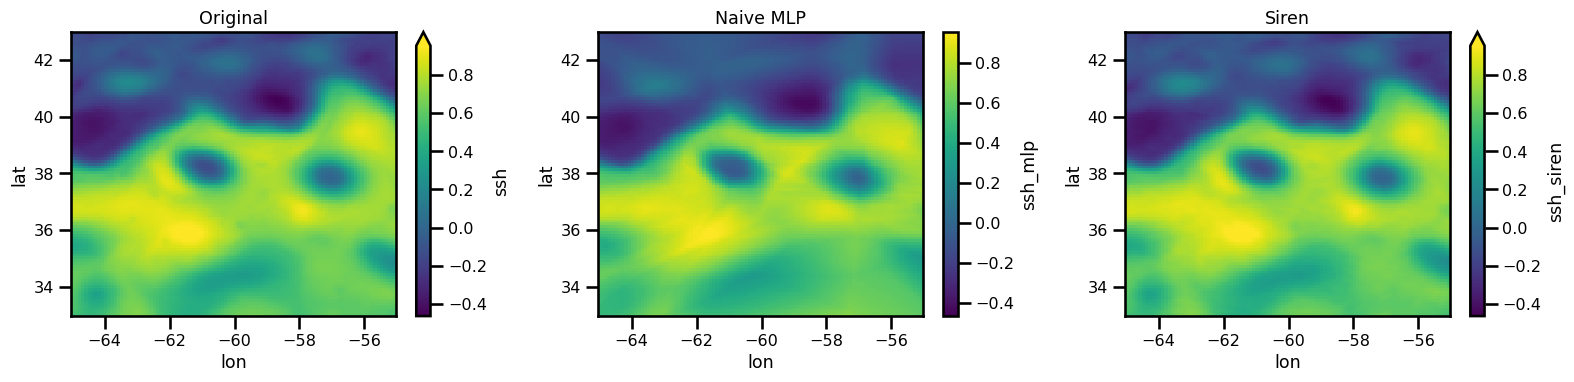

In [46]:
fig, ax = plt.subplots(ncols=3, figsize=(16,4))

vmin = np.min([xrda.ssh.min(), xrda.ssh_mlp.min(), xrda.ssh_siren.min()])
vmax = np.min([xrda.ssh.max(), xrda.ssh_mlp.max(), xrda.ssh_siren.max()])

xrda.ssh.isel(time=0).plot.pcolormesh(ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax)
ax[0].set(title="Original")

xrda.ssh_mlp.isel(time=0).plot.pcolormesh(ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax)
ax[1].set(title="Naive MLP")

xrda.ssh_siren.isel(time=0).plot.pcolormesh(ax=ax[2], cmap="viridis", vmin=vmin, vmax=vmax)
ax[2].set(title="Siren")

plt.tight_layout()
plt.show()

In [47]:
from pint import UnitRegistry
from metpy.constants import earth_gravity as GRAVITY

def get_analysis_xr(da, g: float=GRAVITY):
    
    da.name = "ssh"
    da.attrs["units"] = "m"
    da.attrs["long_name"] = "Sea Surface Height"
    da.attrs["standard_name"] = "sea_surface_height"
    
    da.time.attrs["long_name"] = "Time"
    da.time.attrs["standard_name"] = "time"
    
    da.lon.attrs["units"] = "degrees_east"
    da.lon.attrs["long_name"] = "Longitude"
    da.lon.attrs["standard_name"] = "longitude"
    
    da.lat.attrs["units"] = "degrees_north"
    da.lat.attrs["long_name"] = "Latitude"
    da.lat.attrs["standard_name"] = "latitude"
    
    ds = da.to_dataset()
    
    dx, dy = metpy.calc.lat_lon_grid_deltas(longitude=ds.lon, latitude=ds.lat)
    
    f = metpy.calc.coriolis_parameter(latitude=np.deg2rad(ds.lat.values), )
    
    f0 = f.mean()
    
    ureg = UnitRegistry()
    
    psi = (g/f0) * da 
    ds["psi"] = (("time", "lat", "lon"), psi.data)
    
    dpsi_dx, dpsi_dy = metpy.calc.geospatial_gradient(
        f=psi, latitude=ds.lat, longitude=ds.lon
    )
    
    ds["u"] = (("time", "lat", "lon"), - dpsi_dy.magnitude)
    ds["u"].attrs["units"] = dpsi_dy.u
    ds["u"].attrs["long_name"] = "Zonal Velocity"
    ds["u"].attrs["standard_name"] = "zonal_velocity"
    
    ds["v"] = (("time", "lat", "lon"), dpsi_dx.magnitude)
    ds["v"].attrs["units"] = dpsi_dx.u
    ds["v"].attrs["long_name"] = "Meridional Velocity"
    ds["v"].attrs["standard_name"] = "meridional_velocity"
    
    
    
    q = metpy.calc.geospatial_laplacian(f=psi, latitude=ds.lat, longitude=ds.lon)
    q /= f0
    ds["q"] = (("time", "lat", "lon"), q.values)
    ds["q"].attrs["units"] = q.data.u
    ds["q"].attrs["long_name"] = "Relative Vorticity"
    ds["q"].attrs["standard_name"] = "relative_vorticity"
        
    return ds

In [51]:
ds_ssh_analysis = get_analysis_xr(xrda.ssh)
ds_mlp_analysis = get_analysis_xr(xrda.ssh_mlp)
ds_siren_analysis = get_analysis_xr(xrda.ssh_siren)

In [52]:
ds_ssh_analysis

Magnitude,[[[57853.47515630826 56931.01358713486 55623.90124749118 ... 61185.52719038486 60234.69879082355 59189.338345044336] [59370.01772922579 58190.3899805864 56412.45302772807 ... 61993.19880283927 61366.749580386546 60460.2843038119] [60522.76794821397 59218.37030692662 57072.15880944721 ... 63388.8027518117 62989.30032616125 62336.59959765659] ... [-14025.665184296455 -14169.149092589816 -14453.979501483223 ... -20674.97067601776 -21347.34925898265 -20667.159788770743] [-15490.077089192353 -15143.566280128518 -15101.57637980813 ... -19748.565014328746 -20096.702400560698 -20044.837988379582] [-16739.54019257952 -16175.05500064041 -16521.373114343034 ... -19803.35896232681 -18909.53001718683 -18915.35665218531]]]
Units,meter/second


In [53]:
def plot_analysis(ds):
    

    fig, ax = plt.subplots(ncols=4, figsize=(20,4))

    ds.ssh.isel(time=0).plot.pcolormesh(ax=ax[0], cmap="viridis")
    ds.u.isel(time=0).plot.pcolormesh(ax=ax[1], cmap="gray")
    ds.v.isel(time=0).plot.pcolormesh(ax=ax[2], cmap="gray")
    ds.q.isel(time=0).plot.pcolormesh(ax=ax[3], cmap="RdBu_r")
    plt.tight_layout()
    plt.show()

#### NATL60 Simulation

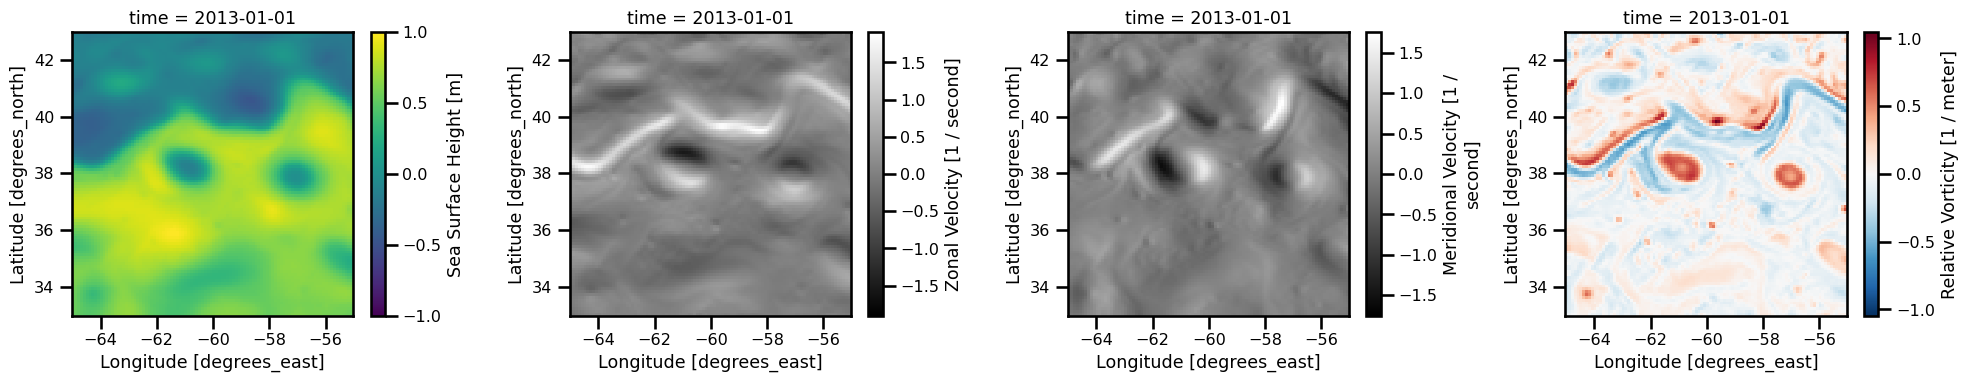

In [54]:
plot_analysis(ds_ssh_analysis, )

#### Naive MLP

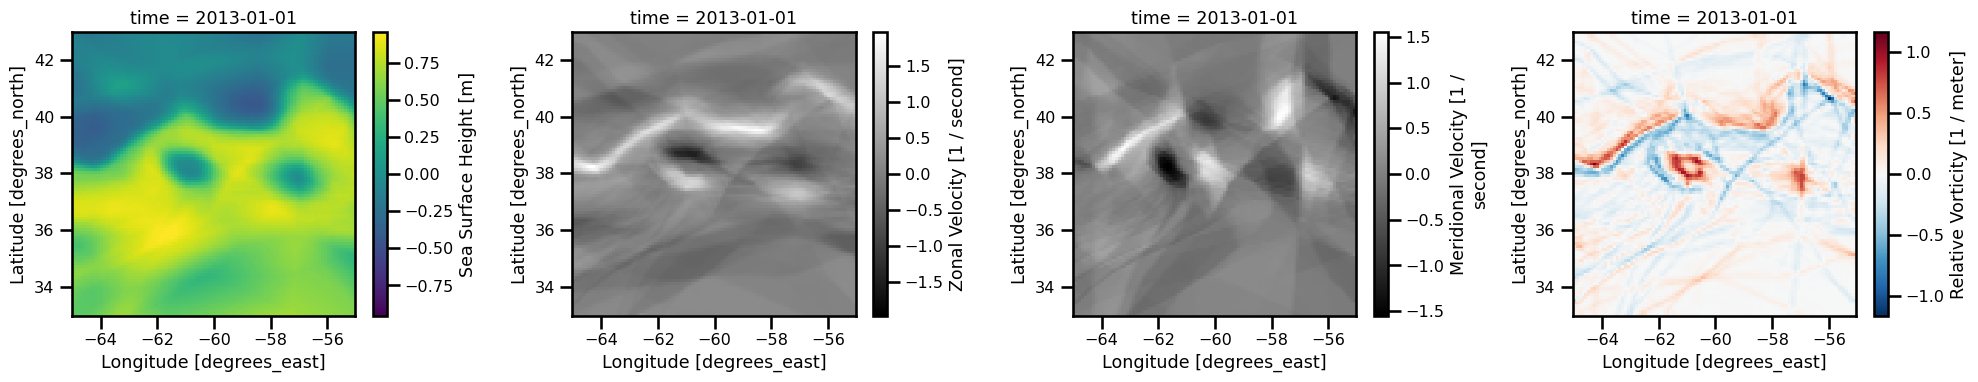

In [55]:
plot_analysis(ds_mlp_analysis, )

#### Latent Modulated SIREN

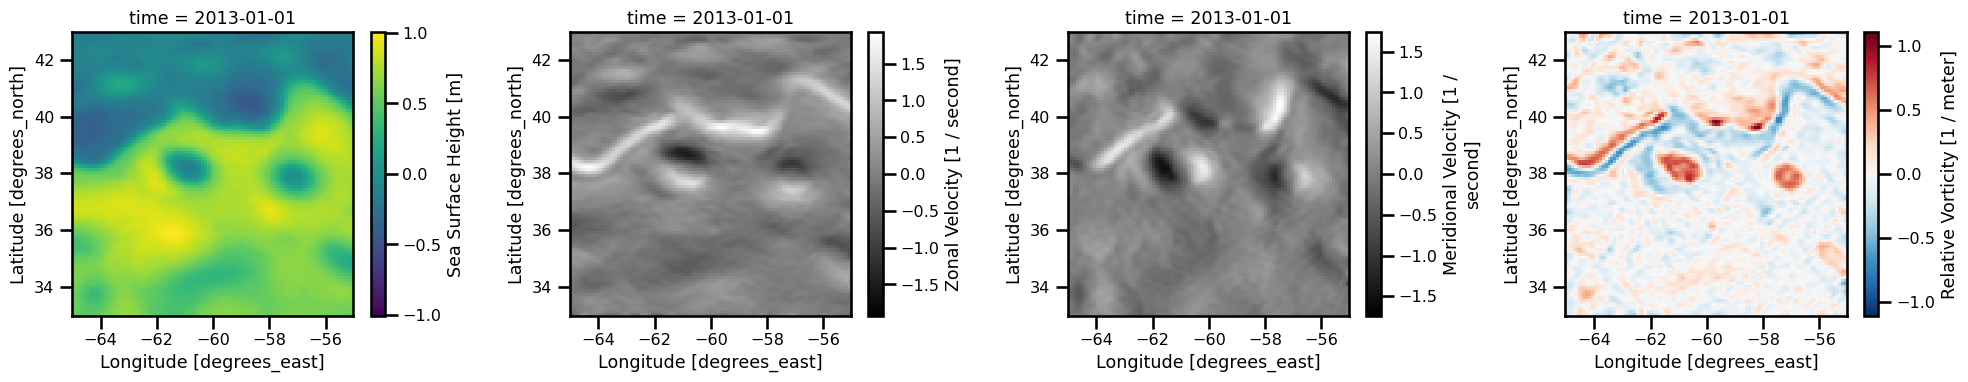

In [56]:
plot_analysis(ds_siren_analysis, )